In [1]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data as td
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as colors

froot = './data/k562_epft_chr22_norm'

df = pd.read_csv(froot + ".csv")

In [2]:
print(df.head())

   seqnames     start       end strand  ensembl_gene_id  score        gc  \
0        22  17736387  17736396      -  ENSG00000015475    0.0  0.699989   
1        22  17736397  17736406      -  ENSG00000015475    0.0  0.699989   
2        22  17736407  17736416      -  ENSG00000015475    0.0  0.699989   
3        22  17736417  17736426      -  ENSG00000015475    0.0  0.158013   
4        22  17736427  17736436      -  ENSG00000015475    0.0  1.241965   

       rpts      ctcf   histone  sj5  sj3  dms  lambda_alphaj      zeta  
0 -0.491843 -0.061105 -0.295750  0.0  0.0  0.0       0.211445  1.204263  
1 -0.491843 -0.061805 -0.309448  0.0  0.0  0.0       0.211445  1.203544  
2 -0.491843 -0.061114 -0.297420  0.0  0.0  0.0       0.211445  1.204176  
3 -0.491843 -0.061809 -0.309120  0.0  0.0  0.0       0.211445  1.056701  
4 -0.491843 -0.061809 -0.309495  0.0  0.0  0.0       0.211445  1.370809  


In [3]:
column_names = np.array(df.columns)
feature_names = column_names[6:-2]
num_features = len(feature_names)
print(feature_names)
num_samples = df.shape[0]

# process read counts
X_ji = df['score'].values

# process GLM simulated elongation rates
Z_ji = df['zeta'].values

['gc' 'rpts' 'ctcf' 'histone' 'sj5' 'sj3' 'dms']


In [4]:
print("Number of Samples: " + str(num_samples))

Number of Samples: 449874


In [5]:
print("Number of Features: " + str(num_features))

Number of Features: 7


In [6]:
#Y_ji is a list of samples containing lists of their feature values
    # [   
    #   sample_1: [feat_1, feat_2,...,feat_n],
    #   sample_2: [feat_1, feat_2,...,feat_n],
    # ]

Y_ji = df.iloc[:, 6:-2].values

In [7]:
C_j = df['lambda_alphaj'].values

In [8]:
gene_ids = df['ensembl_gene_id'].values

In [9]:
cuda_available = torch.cuda.is_available()
print("CUDA (GPU support) is available:", cuda_available)
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)

CUDA (GPU support) is available: False
Number of GPUs available: 0


In [10]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, GeneId, Y_ji, X_ji, C_j, Z_ji):
        self.GeneId = GeneId
        self.Y_ji = Y_ji
        self.X_ji = X_ji
        self.C_j = C_j
        self.Z_ji = Z_ji

    def __len__(self):
        return len(self.Y_ji)

    def __getitem__(self, idx):
        return {
            'GeneId':  self.GeneId[idx],
            'Y_ji':  torch.tensor(self.Y_ji[idx], dtype=torch.float32),
            'X_ji': torch.tensor(self.X_ji[idx], dtype=torch.float32),
            'C_j': torch.tensor(self.C_j[idx], dtype=torch.float32),
            'Z_ji': torch.tensor(self.Z_ji[idx], dtype=torch.float32)
        }

In [23]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 78.2 MB/s eta 0:00:0000:0100:01
  Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
You should consider upgrading via the '/grid/it/data/elzar/easybuild/software/Python/3.9.5-GCCcore-10.3.0/bin/python3.9 -m pip install --upgrade pip' command.


In [11]:
import sklearn
print(sklearn.__version__)


1.3.2


In [18]:
from sklearn.model_selection import GroupShuffleSplit

dataset = CustomDataset(gene_ids, Y_ji, X_ji, C_j, Z_ji)

# Convert gene IDs to numeric labels for GroupShuffleSplit
unique_genes = np.unique(gene_ids)
gene_to_idx = {gene: idx for idx, gene in enumerate(unique_genes)}
group_labels = np.array([gene_to_idx[gene] for gene in gene_ids])

gss_initial = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_val_idx, test_idx = next(gss_initial.split(np.zeros(len(group_labels)), groups=group_labels))

gss_final = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42) 
train_idx, val_idx = next(gss_final.split(np.zeros(len(train_val_idx)), groups=group_labels[train_val_idx]))

train_set = torch.utils.data.Subset(dataset, train_idx)
val_set = torch.utils.data.Subset(dataset, val_idx)
test_set = torch.utils.data.Subset(dataset, test_idx)

batch_size = 64

In [11]:
dataset = CustomDataset(gene_ids, Y_ji, X_ji, C_j, Z_ji)

unique_geneids = df['ensembl_gene_id'].unique()
num_unique_geneids = len(unique_geneids)
train_idx = int(num_unique_geneids * 0.80)
val_idx = int(num_unique_geneids * 0.90)

train_geneids = unique_geneids[:train_idx]
validation_geneids = unique_geneids[train_idx:val_idx]
test_geneids = unique_geneids[val_idx:]

train_indices = [i for i, gene_id in enumerate(dataset.GeneId) if gene_id in train_geneids]
val_indices = [i for i, gene_id in enumerate(dataset.GeneId) if gene_id in validation_geneids]
test_indices = [i for i, gene_id in enumerate(dataset.GeneId) if gene_id in test_geneids]


train_set = torch.utils.data.Subset(dataset, train_indices)
val_set = torch.utils.data.Subset(dataset, val_indices)
test_set = torch.utils.data.Subset(dataset, test_indices)

batch_size = 64

In [19]:
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = nn.Linear(num_features, 1)

if cuda_available:
    if num_gpus > 1:
        print("Using", num_gpus, "GPUs")
        model = torch.nn.DataParallel(model)
    model = model.to('cuda')

print(model)

arr = torch.randn((batch_size,num_features)).to(device)
print(model(arr).shape)
nparm = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: " + str(nparm))

first_param_device = next(model.parameters()).device
print("Model is on device:", first_param_device)

Linear(in_features=7, out_features=1, bias=True)
torch.Size([64, 1])
Number of parameters: 8
Model is on device: cpu


In [20]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, X_ji, C_j, rho_ji):
        #print(rho_ji.shape)
        epsilon = 1e-8
        loss = X_ji * rho_ji + C_j * torch.exp(-rho_ji)
        return (loss).mean()

In [21]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 50

loss_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs

loss_fn = CustomLoss()

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    model.train()
    trndl = DataLoader(train_set, batch_size=batch_size, num_workers=7, shuffle=False, pin_memory=True)
    for i, batch in enumerate(trndl):
        optimizer.zero_grad()
        Y_ji_batch = batch['Y_ji'].to(device)
        X_ji_batch = batch['X_ji'].to(device)
        C_j_batch = batch['C_j'].to(device)
        outputs = model(Y_ji_batch)
        loss = loss_fn(X_ji_batch, C_j_batch, outputs)
        loss.backward()
        optimizer.step()
        loss_hist_train[epoch] += loss.item()
    loss_hist_train[epoch] /= len(trndl)
    del trndl
    
    model.eval()
    valdl = DataLoader(val_set, batch_size=batch_size, num_workers=7, shuffle=False, pin_memory=True)
    with torch.no_grad():
        for batch in valdl:
            Y_ji_batch = batch['Y_ji'].to(device)
            X_ji_batch = batch['X_ji'].to(device)
            C_j_batch = batch['C_j'].to(device)
            outputs = model(Y_ji_batch)
            loss = loss_fn(X_ji_batch, C_j_batch, outputs)
            loss_hist_valid[epoch] += loss.item()
        loss_hist_valid[epoch] /= len(valdl)
    del valdl
    
    print(f'Epoch {epoch+1} trn_loss: '
          f'{loss_hist_train[epoch]:.4f} val_loss: '
          f'{loss_hist_valid[epoch]:.4f}')

Epoch 1
Epoch 1 trn_loss: 91.8827 val_loss: 52.6736
Epoch 2
Epoch 2 trn_loss: 65.0980 val_loss: 38.1594
Epoch 3
Epoch 3 trn_loss: 44.1511 val_loss: 27.6076
Epoch 4
Epoch 4 trn_loss: 29.9032 val_loss: 19.9298
Epoch 5
Epoch 5 trn_loss: 20.2339 val_loss: 14.3583
Epoch 6
Epoch 6 trn_loss: 13.6896 val_loss: 10.3270
Epoch 7
Epoch 7 trn_loss: 9.2732 val_loss: 7.4192
Epoch 8
Epoch 8 trn_loss: 6.3021 val_loss: 5.3292
Epoch 9
Epoch 9 trn_loss: 4.3103 val_loss: 3.8333
Epoch 10
Epoch 10 trn_loss: 2.9805 val_loss: 2.7676
Epoch 11
Epoch 11 trn_loss: 2.0970 val_loss: 2.0131
Epoch 12
Epoch 12 trn_loss: 1.5134 val_loss: 1.4829
Epoch 13
Epoch 13 trn_loss: 1.1307 val_loss: 1.1137
Epoch 14
Epoch 14 trn_loss: 0.8818 val_loss: 0.8596
Epoch 15
Epoch 15 trn_loss: 0.7213 val_loss: 0.6870
Epoch 16
Epoch 16 trn_loss: 0.6185 val_loss: 0.5710
Epoch 17
Epoch 17 trn_loss: 0.5523 val_loss: 0.4930
Epoch 18
Epoch 18 trn_loss: 0.5083 val_loss: 0.4394
Epoch 19
Epoch 19 trn_loss: 0.4772 val_loss: 0.4009
Epoch 20
Epoch 20 

In [22]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"models/Elongation_Model_chr22_cpu_noshuffle_{timestamp}.pth"
torch.save(model.state_dict(), filename)

In [23]:
"""
model = nn.Linear(num_features, 1)
model.load_state_dict(torch.load("models/Elongation_Model_chr22.pth"))
cuda_available = torch.cuda.is_available()
print("CUDA (GPU support) is available:", cuda_available)
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)
if cuda_available:
    if num_gpus > 1:
        print("Using", num_gpus, "GPUs")
        model = torch.nn.DataParallel(model)
    model = model.to('cuda')

first_param_device = next(model.parameters()).device
print("Model is on device:", first_param_device)
"""

'\nmodel = nn.Linear(num_features, 1)\nmodel.load_state_dict(torch.load("models/Elongation_Model_chr22.pth"))\ncuda_available = torch.cuda.is_available()\nprint("CUDA (GPU support) is available:", cuda_available)\nnum_gpus = torch.cuda.device_count()\nprint("Number of GPUs available:", num_gpus)\nif cuda_available:\n    if num_gpus > 1:\n        print("Using", num_gpus, "GPUs")\n        model = torch.nn.DataParallel(model)\n    model = model.to(\'cuda\')\n\nfirst_param_device = next(model.parameters()).device\nprint("Model is on device:", first_param_device)\n'

In [24]:
weights = model.weight.data.cpu().numpy()
bias = model.bias.data.cpu().numpy()

combined = ', '.join([f'"{s}": {f}' for s, f in zip(feature_names, weights[0])])
print(combined)

"gc": -0.05025668069720268, "rpts": 0.03487689793109894, "ctcf": -0.003233246272429824, "histone": -0.036671046167612076, "sj5": -0.018671337515115738, "sj3": 0.016096368432044983, "dms": -0.020677300170063972


In [ ]:
# GLM K

# gc: -0.240107566
# rpts: 0.063179057
# ctcf: -0.008355491
# histone: -0.043173335
# sj5: -0.114737868
# sj3: -0.181587543
# dms: -0.080544917

<function matplotlib.pyplot.show(close=None, block=None)>

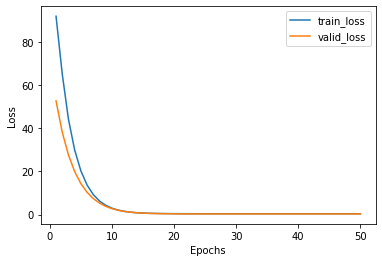

In [25]:
from matplotlib import pyplot as plt
epochs = range(1, len(loss_hist_train) + 1)
plt.plot(epochs, loss_hist_train, label='train_loss')
plt.plot(epochs, loss_hist_valid, label='valid_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show 

In [26]:
def plot_data(simulated_zeta, predicted_zeta):
    indices = range(len(simulated_zeta))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    ax.plot(indices, predicted_zeta, color='blue', alpha=0.4)
    ax.plot(indices, simulated_zeta, color='orange', alpha=0.4)
    
    ax.scatter(indices, predicted_zeta, color='blue', label='Predicted Zeta')
    ax.scatter(indices, simulated_zeta, color='orange', label='Simulated Zeta')
    
    ax.set_title('Predicted vs Simulated Elongation Rate')
    ax.set_xlabel('Index')
    ax.set_ylabel('Elongation Rate')
    ax.legend()

    plt.show()


In [27]:
tstdl = DataLoader(test_set, batch_size=batch_size, num_workers=0, shuffle=False, pin_memory=True)

In [28]:
model.eval()

data_iter = iter(tstdl)

number of samples: 5
predicted zeta:
tensor([0.9107, 0.9112, 0.9108, 0.9364, 0.8867, 0.9620, 0.9888, 1.0442, 1.0731,
        0.9623, 0.9889, 1.0726, 1.0439, 0.9362, 0.9882, 0.9616, 0.9874, 0.9339,
        0.9871, 0.8613, 0.9597, 0.9097, 0.9067, 0.9601, 1.1064, 1.0449, 1.0768,
        1.0162, 0.9921, 1.0164, 0.9927, 1.0201, 0.9650, 1.0478, 0.9926, 0.9659,
        0.9628, 0.9918, 0.9929, 1.0197, 0.9663, 0.9931, 1.1695, 1.1077, 1.0490,
        0.9935, 0.9936, 0.9670, 0.9938, 0.9939, 0.9939, 0.9940, 1.0215, 0.9940,
        1.0215, 1.0215, 0.9160, 0.9672, 1.1389, 1.1388, 1.0493, 0.9936, 1.0209,
        0.9933])
simulated zeta:
tensor([0.8304, 0.8309, 0.8304, 0.9463, 0.7295, 1.0776, 1.2277, 1.5927, 1.8142,
        1.0780, 1.2278, 1.8133, 1.5922, 0.9461, 1.2269, 1.0771, 1.2257, 0.9434,
        1.2251, 0.6391, 1.0745, 0.8292, 0.8260, 1.0751, 1.6344, 1.2558, 1.4352,
        1.1019, 0.9712, 1.1022, 0.9718, 1.1069, 0.8521, 1.2600, 0.9716, 0.8531,
        0.8499, 0.9707, 0.9720, 1.1064, 0.8535, 0.

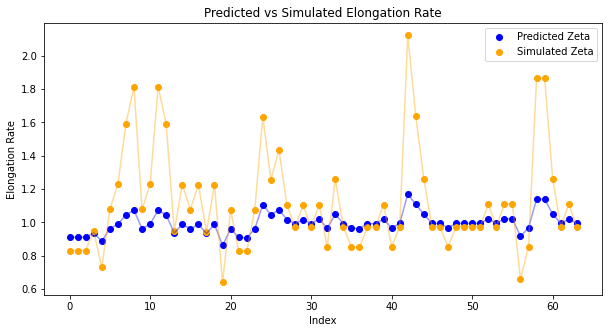

number of samples: 5
predicted zeta:
tensor([1.0206, 1.0486, 0.9662, 0.9660, 0.9925, 1.0197, 0.9395, 0.9393, 1.0761,
        1.1676, 1.1055, 0.9912, 0.9910, 1.0752, 1.0181, 0.9906, 1.0179, 1.0178,
        0.9904, 1.0458, 0.9637, 0.9903, 1.0177, 0.9576, 0.9577, 0.9320, 0.9321,
        1.0116, 0.9324, 0.9074, 0.9584, 0.9585, 0.9587, 1.1363, 1.0192, 0.9920,
        0.9922, 0.9923, 1.0199, 1.0201, 0.9928, 0.9929, 1.0205, 0.9665, 1.0207,
        0.9933, 0.9666, 0.9667, 1.0490, 1.1382, 0.9933, 0.9932, 0.9931, 0.9663,
        1.0203, 1.0201, 0.9658, 0.9656, 0.9654, 1.0192, 0.9649, 0.9647, 1.0119,
        1.0116])
simulated zeta:
tensor([1.1075, 1.2612, 0.8534, 0.8532, 0.9715, 1.1063, 0.7486, 0.7484, 1.4342,
        2.1187, 1.6329, 0.9701, 0.9699, 1.4328, 1.1043, 0.9694, 1.1040, 1.1039,
        0.9691, 1.2572, 0.8508, 0.9691, 1.1038, 1.0718, 1.0719, 0.9412, 0.9413,
        1.3910, 0.9416, 0.8268, 1.0728, 1.0730, 1.0732, 1.8604, 1.1057, 0.9710,
        0.9712, 0.9714, 1.1066, 1.1068, 0.9719, 0.

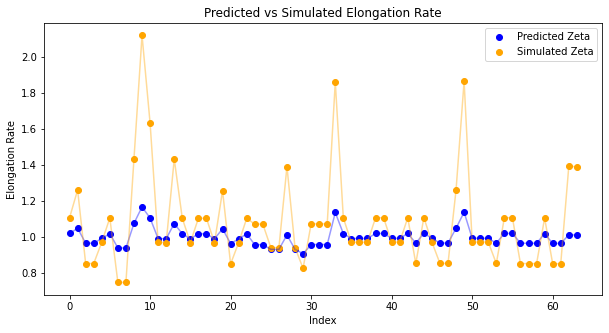

number of samples: 5
predicted zeta:
tensor([0.9319, 0.9573, 0.9313, 0.8816, 0.9056, 0.9302, 0.9049, 0.9046, 0.8800,
        0.9040, 0.9037, 0.9034, 0.9280, 0.9534, 0.9532, 0.9530, 0.8780, 0.9270,
        0.9525, 0.9267, 0.9523, 0.9266, 0.9017, 0.9017, 0.9266, 0.9017, 0.9030,
        0.8548, 0.9517, 0.9488, 0.9446, 0.8425, 0.9087, 0.9279, 0.9223, 0.9427,
        0.9134, 0.8624, 0.9094, 1.0424, 0.9366, 0.9399, 0.8921, 0.8807, 0.8810,
        0.9305, 0.8814, 0.8579, 0.9459, 0.9472, 0.9752, 0.8991, 0.8983, 0.8963,
        0.8933, 0.8894, 0.8894, 0.8530, 0.8899, 1.0267, 0.8988, 0.9767, 0.8764,
        0.9775])
simulated zeta:
tensor([0.9410, 1.0714, 0.9402, 0.7245, 0.8248, 0.9390, 0.8241, 0.8237, 0.7229,
        0.8231, 0.8228, 0.8224, 0.9364, 1.0662, 1.0659, 1.0656, 0.7210, 0.9352,
        1.0650, 0.9349, 1.0647, 0.9347, 0.8206, 0.8206, 0.9347, 0.8207, 0.8591,
        0.6606, 1.1005, 1.0789, 1.0492, 0.6024, 0.8567, 0.9378, 0.9027, 0.9935,
        0.8483, 0.6412, 0.8236, 1.5791, 0.9484, 0.

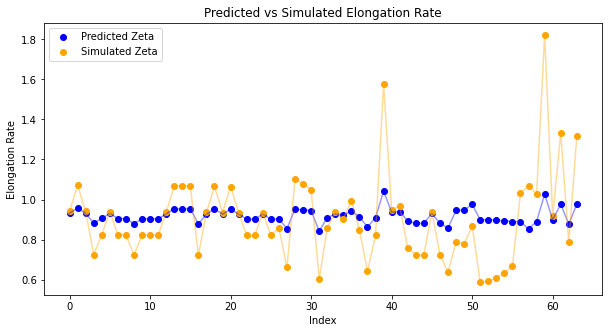

number of samples: 5
predicted zeta:
tensor([0.9512, 1.0111, 0.9574, 0.8585, 0.9572, 0.9571, 0.9570, 0.9062, 0.9568,
        0.9310, 0.8816, 0.8815, 0.9308, 0.9308, 0.8814, 0.9307, 0.9056, 0.9827,
        0.8812, 0.8575, 0.9305, 0.9055, 0.9304, 0.8811, 0.8810, 1.0095, 0.9302,
        0.9301, 0.9050, 0.8806, 0.9048, 0.9297, 0.9046, 0.9045, 0.8334, 0.9042,
        0.9547, 0.8797, 0.8796, 0.9038, 0.8794, 0.9286, 0.8557, 0.9542, 0.9542,
        0.9542, 0.8794, 0.9543, 0.9288, 0.9546, 0.9547, 0.9292, 0.8802, 0.9047,
        0.9299, 0.9052, 0.9825, 0.9307, 0.9059, 0.8818, 0.9064, 0.9317, 0.9319,
        0.9320])
simulated zeta:
tensor([1.1554, 1.3902, 1.0715, 0.6366, 1.0713, 1.0711, 1.0710, 0.8255, 1.0707,
        0.9400, 0.7245, 0.7245, 0.9397, 0.9397, 0.7243, 0.9396, 0.8249, 1.2188,
        0.7242, 0.6358, 0.9394, 0.8247, 0.9393, 0.7240, 0.7239, 1.3876, 0.9390,
        0.9389, 0.8242, 0.7236, 0.8240, 0.9384, 0.8238, 0.8237, 0.5574, 0.8234,
        1.0680, 0.7227, 0.7226, 0.8229, 0.7224, 0.

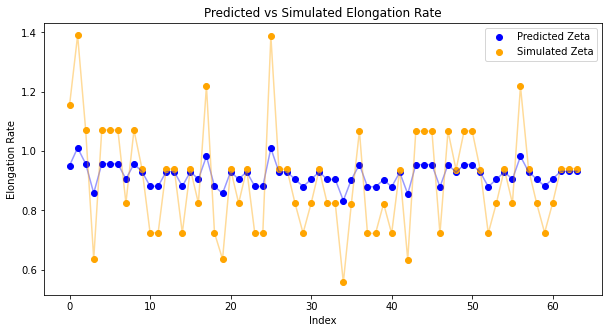

In [29]:
for i in range(0, 4):
    inputs = next(data_iter) 
    print("number of samples: " + str(len(inputs)))

    with torch.no_grad():
        y_inputs = inputs['Y_ji'].to(device)
        rho_ji = model(y_inputs)

    simulated_zeta = 1 / inputs['Z_ji']
    # convert log(Z) outputs to Z
    predicted_zeta = torch.exp(rho_ji.cpu().squeeze())
    print("predicted zeta:")
    print(predicted_zeta)

    print("simulated zeta:")
    print(simulated_zeta)

    plot_data(simulated_zeta, predicted_zeta)

In [21]:
import torch.nn.functional as F

predicted_zeta = []
simulated_zeta = []
with torch.no_grad():
    for batch in tstdl:
        y_inputs = batch['Y_ji'].to(device)
        rho_ji = model(y_inputs)
        # convert log(Z) outputs to Z
        predicted_zeta.append(torch.exp(rho_ji.cpu()))
        simulated_zeta.append(1 / batch['Z_ji'])

predicted_zeta = torch.cat(predicted_zeta, dim=0)
simulated_zeta = torch.cat(simulated_zeta, dim=0)
mae = F.l1_loss(predicted_zeta.squeeze(), simulated_zeta)
mse = F.mse_loss(predicted_zeta.squeeze(), simulated_zeta)

print(f"Mean Absolute Error: {mae.item():.4f}")
print(f"Mean Squared Error: {mse.item():.4f}")

Mean Absolute Error: 0.2156
Mean Squared Error: 0.0860
